# Appendix: Testing the impact Values

This Jupyter notebook contains supplementary material for the research paper titled "Introduction to impact Values in Cooperative Game Theory: An innovative Shapley-Based Approach, with Marketing Case Study". 

### Importing the needed libraries:

- **"pandas"**: used for handling the dataset.
- **"numPy", "math", "itertools"**: used to handle mathematical operations.
- **"seaborn", "matplotlib"**: used to plot the impact Matrix.
- **"deap"**: Used to set up the Genetic Algorithm needed for the optimisation task

Make sure every module listed is installed on your machine before running the code.

In [1]:
import pandas as pd
import platform
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from math import factorial
from itertools import combinations
import more_itertools as mit
from deap import base, creator, tools, algorithms

### Dataset loading

In [2]:
# Load the dataset
file_path = 'data.xlsx'
data = pd.read_excel(file_path)

data.head()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Consumer_ID,Existing_customer,Relation_length,CLV,Firm_banner,Email_group,Banner_no_click,Banner_click,SEA_product_click,SEA_brand_click,Price_comp_click,Email_no_click,Email_click,Direct_visit,Social_visit,First_channel,Last_channel,Amount_touchpoints,Flyer_region,Purchase
0,1,0,0,0.000000,1,0,0,0,0,0,1,0,0,3,1,Social_visit,Direct_visit,6,1,0
1,2,1,16,565.235935,1,0,0,0,0,0,1,0,0,3,0,Price_comp_click,Direct_visit,5,1,1
2,3,1,9,2430.037780,0,1,1,0,0,0,0,0,0,3,1,Social_visit,Direct_visit,6,0,1
3,4,1,9,1423.361957,0,0,1,0,0,0,1,0,0,3,2,Direct_visit,Social_visit,7,0,0
4,5,1,35,2505.091038,1,1,2,1,0,0,0,0,0,3,3,Social_visit,Direct_visit,11,0,1


### Selecting the useful columns for the study

Next, the eleven columns useful for the study mentioned in the paper are selected from the dataset.

Each cell is converted to a binary input explaining whether the consumer interacted with the channel or not.

Then, the repeated paths in the dataset are aggregated by taking the sum of purchases.

The output is a dataset with unique rows representing consumers' paths and the sum of purchases resulting from each path.

This new dataset will be used to compute the Shapley and impact values as defined in the paper.

In [3]:
# Identifying the columns representing the marketing channels and the 'Purchase' column
marketing_channels = [
    "Firm_banner", "Email_group", "Banner_no_click", "Banner_click",
    "SEA_product_click", "SEA_brand_click", "Price_comp_click", "Email_no_click",
    "Email_click", "Direct_visit", "Social_visit"
]
purchase_column = "Purchase"

# Selecting only the relevant columns
selected_data = data[marketing_channels + [purchase_column]]

# Converting all inputs in the cells to 0s and 1s (if an input is bigger than 1, change it to 1)
selected_data = selected_data.applymap(lambda x: 1 if x > 0 else 0)

# Group by the marketing channels and sum the purchases
grouped_data = selected_data.groupby(marketing_channels).sum().reset_index()

grouped_data.head()

grouped_data.to_excel('paths.xlsx')


/var/folders/9k/jzxy5b0j6zjcx9kq2ns60_f80000gn/T/ipykernel_67512/1373678451.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  selected_data = selected_data.applymap(lambda x: 1 if x > 0 else 0)


### Occuurrences of channels in the dataset

A checking of the occurrences of the previously mentioned channels is done to check the presence of each one in the dataset, lower values could affect the computation of Shapley and impact Values for a channel.

In [4]:
# Compute the occurrence of each channel by counting non-zero values in each column
channel_occurrences = (grouped_data.iloc[:, :-1] != 0).sum()

channel_occurrences

Firm_banner          482
Email_group          618
Banner_no_click      475
Banner_click         323
SEA_product_click    397
SEA_brand_click      440
Price_comp_click     408
Email_no_click       293
Email_click          242
Direct_visit         510
Social_visit         484
dtype: int64

Next, we make a dictionary in which we store the coalitions as keys and the corresponding number of conversions as values.

In [5]:
# Dictionary to store the total conversions for each combination of channels
coalitions_dict = {}

for index, row in grouped_data.iterrows():
    coalition = {channel for channel in marketing_channels if row[channel] == 1}
    total_conversions = row['Purchase'] 
    coalitions_dict[frozenset(coalition)] = total_conversions

### Imputation of missing values 

In order to have an accurate computation of Shapley and Impact values, we impute the missing coalitions into the dataset. The extension used is the following:
$$
\nu = \frac{\underline{v}+\overline{v}}{2} \ \ \ \text{where:} \ \ \
   \begin{cases} 
      \underline{v} = \max\limits_{\substack{\\ T_i \in \mathcal{K}, \ i = 1, 2, \dots, s \\ \bigcup_{i} T_i \subseteq S, \ T_i \text{ are disjoint}}} \sum_{i=1}^{s} v(T_i) \\
      \overline{v} = \min\limits_{\substack{\hat{S} \in \mathcal{K}, \ \hat{S} \supseteq S}} (v(\hat{S}) - \underline{v}(\hat{S}\setminus S))
   \end{cases}
$$

First, we start by checking if all signletons coalitions and if the grand coalition are present, since they are essential for the imputation task.

In [6]:
liste = []
for S in combinations(marketing_channels, 1):
    if frozenset(S) in coalitions_dict:
        liste.append(S)
        print(S, coalitions_dict[frozenset(S)])

('Banner_no_click',) 0
('Banner_click',) 0
('SEA_product_click',) 1
('SEA_brand_click',) 4
('Price_comp_click',) 2
('Direct_visit',) 15


As we can see, some singletons are missing, we proceed by giving the missing singletons a value of 0. 

In [7]:
for subset_tuple in combinations(marketing_channels, 1):
    if frozenset(subset_tuple) not in coalitions_dict:
        coalitions_dict[frozenset(subset_tuple)] = 0

Since the grand coalition has a very small value we proceed by adding to it the maximal value in the dictionary.

In [8]:
print(max(coalitions_dict.values()))

562


In [9]:
for S in combinations(marketing_channels, 11):
    if frozenset(S) in coalitions_dict:
        coalitions_dict[frozenset(S)] = max(coalitions_dict.values()) + coalitions_dict[frozenset(S)]
        print(S, coalitions_dict[frozenset(S)])

('Firm_banner', 'Email_group', 'Banner_no_click', 'Banner_click', 'SEA_product_click', 'SEA_brand_click', 'Price_comp_click', 'Email_no_click', 'Email_click', 'Direct_visit', 'Social_visit') 584


We proceed by imputing the missing values.

In [10]:
coalitions_dict_copy = coalitions_dict.copy()

In [11]:
for S in range(len(marketing_channels)):
    for subset_tuple in combinations(marketing_channels, S):
        if frozenset(subset_tuple) not in coalitions_dict:
            coalitions_dict[frozenset(subset_tuple)] = 0

In [12]:
def compute_v_underline(S, v):
    max_value = 0
    for partition in mit.set_partitions(S):
        if (frozenset(i) in v for i in partition):
            value_sum = sum(v[frozenset(i)] for i in partition)
            max_value = max(max_value, value_sum)
    return max_value if max_value > 0 else 0

def compute_v_overline(S, v):
    subsets = [i for i in v.keys() if (len(i) > len(S) or i==S)]
    min_value = float('inf')
    for subset in subsets:
        if set(S).issubset(set(subset)):
            residual_set = frozenset(set(subset) - set(S))
            value = v[subset] - compute_v_underline(residual_set, v)
            min_value = min(min_value, value)
    return min_value if min_value > 0 else 0

def compute_nu(S, v):
    return int((compute_v_underline(S, v) + compute_v_overline(S, v))/2)

for i in range(1, len(marketing_channels)):
    for S in combinations(marketing_channels, i):
        if frozenset(S) not in coalitions_dict_copy:
            coalitions_dict[frozenset(S)] = compute_nu(S, coalitions_dict)

### Shapley Values

Now, a function computing Shapley Values for each marketing channel is defined. The output is a dictionary containing each marketing channel and its corresponfing Shapley Value.

The formula for the Shaply Values is the following:

$\phi_i(v) = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} \left(v(S \cup \{i\}) - v(S)\right)$

In [13]:
def get_shapley(coalitions_dict, channel_columns):
    shapley_values_dict = {channel: 0 for channel in channel_columns}
    n = len(channel_columns)

    # Function to check if the coalition is in the coalitions dictionary
    def is_coalition_present(coalition):
        return frozenset(coalition) in coalitions_dict

    # Function to get the total conversions for a given coalition
    def get_total_conversions(coalition):
        return coalitions_dict[frozenset(coalition)]

    # Iterattion over each channel
    for channel in channel_columns:
        checked = []
        for S in range(1, n):
            for subset_tuple in combinations(channel_columns, S):
                subset = set(subset_tuple) 
                if frozenset(subset) not in checked:
                    if channel not in subset:
                        checked.append(frozenset(subset))
                        subset_with_channel = subset | {channel}  
                        if is_coalition_present(frozenset(subset)) and is_coalition_present(frozenset(subset_with_channel)):
                            subset_value = get_total_conversions(frozenset(subset))
                            subset_with_channel_value = get_total_conversions(frozenset(subset_with_channel))
                            weight = (factorial(S) * factorial(n - S - 1)) / factorial(n)
                            marginal_contribution = subset_with_channel_value - subset_value
                            shapley_values_dict[channel] += marginal_contribution * weight

    return shapley_values_dict


Now, Shapley Values are computed for each marketing channel.

In [14]:
shapley_values = get_shapley(coalitions_dict, marketing_channels)
shapley_values

{'Firm_banner': np.float64(86.93841991341995),
 'Email_group': np.float64(-28.353643578643585),
 'Banner_no_click': np.float64(11.102308802308812),
 'Banner_click': np.float64(55.80349927849928),
 'SEA_product_click': np.float64(60.424891774891776),
 'SEA_brand_click': np.float64(64.5974025974026),
 'Price_comp_click': np.float64(63.65660173160173),
 'Email_no_click': np.float64(61.57175324675325),
 'Email_click': np.float64(64.44397546897547),
 'Direct_visit': np.float64(60.27438672438673),
 'Social_visit': np.float64(81.54040404040403)}

### Impact Values

Using a similar approach, a function computing Impact Values for each pair of channels is defined. The output is a dictionary containing each pair of marketing channels and its corresponfing Impact Value.

The formula introduced for the Impact Values is the following:

$\phi_{ij}(v) = \sum_{S \subseteq N \setminus \{i,j\}} \frac{|S|!(|N|-|S|-2)!}{|N-1|!} \left(v(S \cup \{i,j\}) - v(S \cup \{j\})\right)$

In [15]:
def get_impact_values(coalitions_dict, channel_columns):
    impact_values_dict = {(i, j): 0 for i in channel_columns for j in channel_columns if i != j}
    n = len(channel_columns)

    # Function to check if the coalition is in the coalitions_dict
    def is_coalition_present(coalition):
        return frozenset(coalition) in coalitions_dict

    # Function to get the total conversions for a given coalition
    def get_total_conversions(coalition):
        return coalitions_dict.get(frozenset(coalition), 0)

    for i in channel_columns:
        for j in channel_columns:
            if i != j:
                checked = []
                for S in range(1, n):
                    for subset_tuple in combinations(channel_columns, S):
                        subset = set(subset_tuple) 
                        if frozenset(subset) not in checked:
                            checked.append(frozenset(subset))
                            if not(i in subset or j in subset):
                                subset_with_i = subset | {i}
                                subset_with_i_j = subset | {i, j}
                                if is_coalition_present(subset_with_i) and is_coalition_present(subset_with_i_j):
                                    subset_with_i_value = get_total_conversions(subset_with_i)
                                    subset_with_i_j_value = get_total_conversions(subset_with_i_j)
                                    weight = factorial(S) * factorial(n - S - 2) / factorial(n - 1)
                                    marginal_contribution = subset_with_i_j_value - subset_with_i_value
                                    impact_values_dict[(i, j)] += marginal_contribution * weight
            

    return impact_values_dict


Now, Impact Values are computed for each pair of marketing channel.

In [16]:
impact_values = get_impact_values(coalitions_dict, marketing_channels)

### Impact Matrix

A function constructing the Impact Matrix is defined using the Shapley (in the diagonal) and Impact Values (off-diagonal values of the matrix) computed in the previous step.

The Impact Matrix is defined as follows:

$$
M(v) = 
\begin{bmatrix}
    \phi_1(v) & \phi_{1,2}(v) & \cdots & \phi_{1,n}(v) \\
    \phi_{2,1}(v) & \phi_2(v) & \cdots & \phi_{2,n}(v) \\
    \vdots & \vdots & \ddots & \vdots \\
    \phi_{n,1}(v) & \phi_{n,2}(v) & \cdots & \phi_n(v)
\end{bmatrix}
$$

In [17]:
def get_impact_matrix(shapley_values, impact_values, channel_columns):
    n = len(channel_columns)
    impact_matrix = np.zeros((n, n))
    for i, channel in enumerate(channel_columns):
        impact_matrix[i, i] = shapley_values[channel]
    for i, channel_i in enumerate(channel_columns):
        for j, channel_j in enumerate(channel_columns):
            if i != j:
                impact_matrix[i, j] = impact_values[channel_i, channel_j]

    return impact_matrix

Now, we compute the Impact Matrix.

In [18]:
impact_matrix = get_impact_matrix(shapley_values, impact_values, marketing_channels)

A heatmap representing the Impact Matrix is plotted.

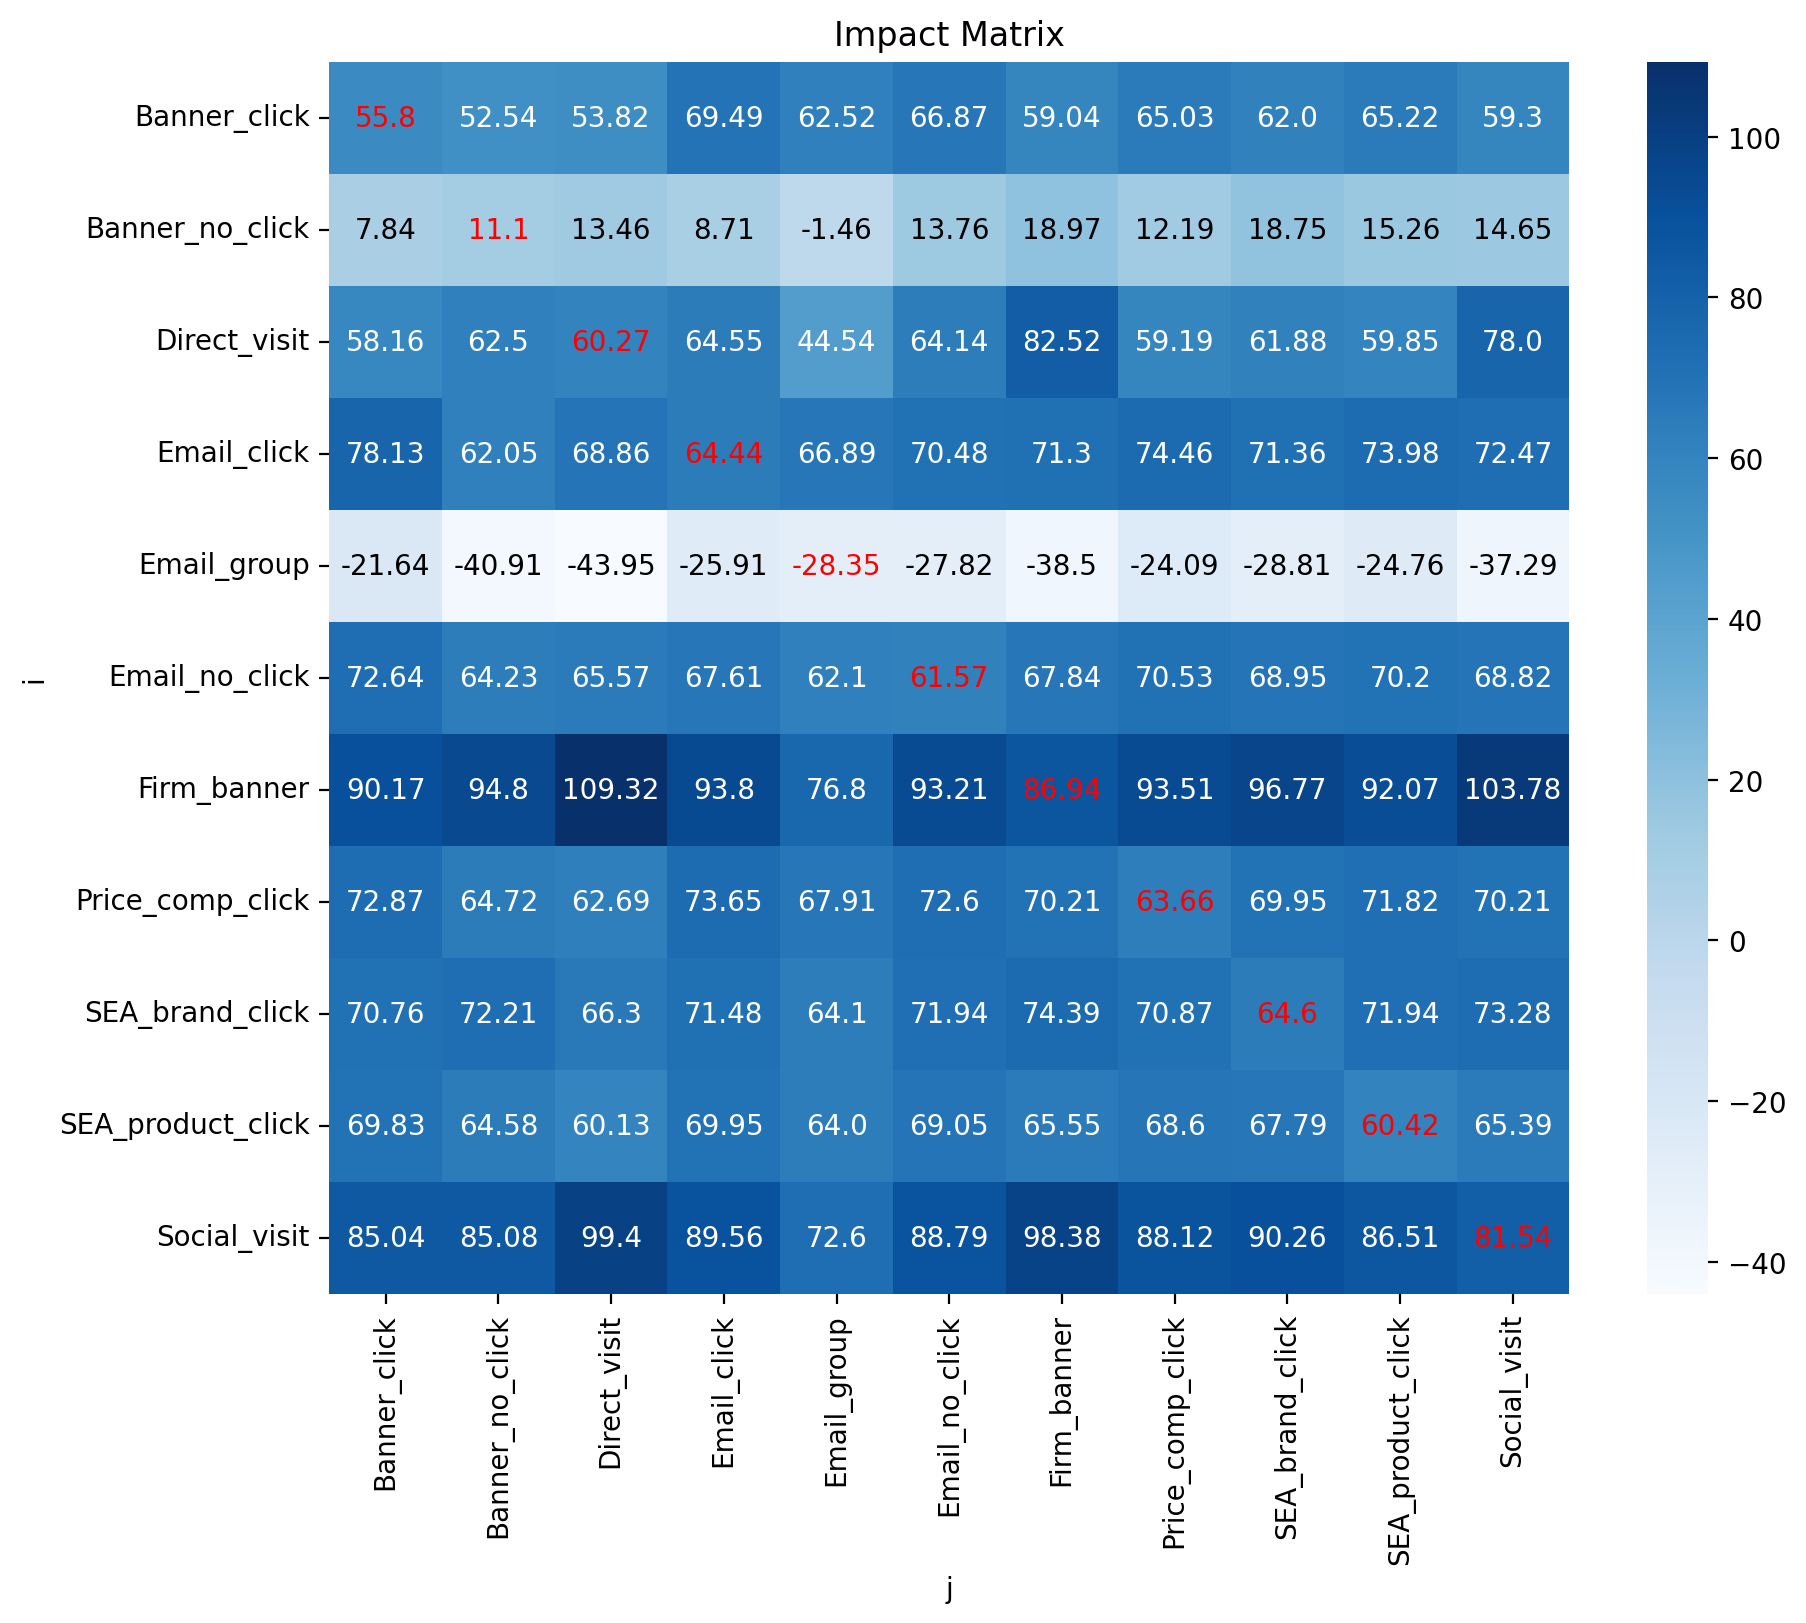

In [19]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

channels = set()
for pair in impact_values.keys():
    channels.update(pair)
channels = sorted(list(channels))

impact_matrix_df = pd.DataFrame(index=channels, columns=channels, data=0.0)
for (channel1, channel2), value in impact_values.items():
    impact_matrix_df.at[channel1, channel2] = value

for channel, value in shapley_values.items():
    impact_matrix_df.at[channel, channel] = value

plt.figure(figsize=(10, 8))
ax = sns.heatmap(impact_matrix_df.T, cmap='Blues', annot=False)

# Normalize the colormap limits
color_min, color_max = ax.collections[0].get_clim()

# Annotate non-diagonal elements with adaptive text color
for i in range(impact_matrix_df.shape[0]):
    for j in range(impact_matrix_df.shape[1]):
        if i != j:
            value = round(impact_matrix_df.iloc[j, i], 2)  # Get the value
            rgba_color = ax.collections[0].to_rgba(impact_matrix_df.iloc[j, i])  # Get RGBA for the cell value
            luminance = 0.2126 * rgba_color[0] + 0.7152 * rgba_color[1] + 0.0722 * rgba_color[2]  # Calculate luminance
            text_color = "white" if luminance < 0.7 else "black"  # Choose white for dark cells, black for light
            ax.text(j + 0.5, i + 0.5, value, ha="center", va="center", color=text_color)

# Annotate diagonal elements in red
for i in range(impact_matrix_df.shape[0]):
    text = ax.text(i + 0.5, i + 0.5, round(impact_matrix_df.iloc[i, i], 2),
                   ha="center", va="center", color="red")
    
ax.set_xlabel('j')
ax.set_ylabel('i')

plt.savefig("plot.png")

plt.title("Impact Matrix")
plt.show()

### Optimisation Task

In this section, we set the budget constraint and the cost of each channel, then we set up the Genetic Algorithm with the specifications mentioned in the paper.

In [20]:
# Define the channel costs and budget
channel_costs = {
    'Firm_banner': 146, 
    'Email_group': 94, 
    'Banner_no_click': 100,
    'Banner_click': 98, 
    'SEA_product_click': 82, 
    'SEA_brand_click': 100, 
    'Price_comp_click': 61, 
    'Email_no_click': 104, 
    'Email_click': 90, 
    'Direct_visit': 72, 
    'Social_visit': 135
}

budget = 500

In the next section, the Genetic Algorithm using only Shapley Values is set up, and the optimal coalition of marketing channels is predicted.

In [21]:
random.seed(123)

# Setup for Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(marketing_channels))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval(individual):
    # Sum of Shapley Values for each channel in the individual
    total_value = sum(impact_matrix[i, i] * individual[i] for i in range(len(marketing_channels)))
    
    # Calculate total cost
    total_cost = sum(channel_costs[marketing_channels[i]] * individual[i] for i in range(len(marketing_channels)))

    # Check if the total cost is within the budget
    if total_cost > budget:
        return -1,

    return total_value,

# Genetic operators
toolbox.register("evaluate", eval)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Creating the population
population = toolbox.population(n=100)

# Running the genetic algorithm
ngen = 100
result = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=ngen, verbose=False)

# Extracting the best solution
best_ind = tools.selBest(population, k=1)[0]
best_channels = [marketing_channels[i] for i in range(len(best_ind)) if best_ind[i] == 1]
best_value = eval(best_ind)[0]

print("Best Subset of Channels:", best_channels)
print("Best Value:", best_value)

Best Subset of Channels: ['Firm_banner', 'SEA_product_click', 'SEA_brand_click', 'Price_comp_click', 'Email_click']
Best Value: 340.0612914862915


Next, the Genetic Algorithm using both Shapley and Impact Values is set up, and the optimal coalition of marketing channels is predicted.

In [22]:
random.seed(123)

# Setup for Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(marketing_channels))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval(individual):
    # Sum of Shapley Values for each channel in the individual
    diagonal_sum = sum(impact_matrix[i, i] * individual[i] for i in range(len(marketing_channels)))

    # Sum of impact Values for all pairs of channels in the individual
    impact_sum = sum(impact_matrix[j, i] / 10 * individual[i] * individual[j] for i in range(len(marketing_channels)) for j in range(len(marketing_channels)) if i != j)

    # Total value is the sum of diagonal values and impact values
    total_value = diagonal_sum + impact_sum

    # Calculate total cost
    total_cost = sum(channel_costs[marketing_channels[i]] * individual[i] for i in range(len(marketing_channels)))

    # Check if the total cost is within the budget
    if total_cost > budget:
        return -1,  # Penalty for exceeding budget

    return total_value,


# Genetic operators
toolbox.register("evaluate", eval)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Creating the population
population = toolbox.population(n=100)

# Running the genetic algorithm
ngen = 100
result = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=ngen, verbose=False)

# Extracting the best solution
best_ind = tools.selBest(population, k=1)[0]
best_channels = [marketing_channels[i] for i in range(len(best_ind)) if best_ind[i] == 1]
best_value = eval(best_ind)[0]

print("Best Subset of Channels:", best_channels)
print("Best Value:", best_value)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best Subset of Channels: ['Firm_banner', 'SEA_product_click', 'Price_comp_click', 'Direct_visit', 'Social_visit']
Best Value: 511.3590692640694


Last, a function calculating the total number of conversions for a specific coalition of channels is created. This function is used to get the number of conversions from each of the two outputs for comparative purposes.

In [23]:
def conversions(df, coalition):
    checked = []
    purchases = 0
    for S in range(1, len(coalition) + 1):
        for subset in combinations(coalition, S):
            subset = frozenset(subset)
            if subset not in checked:
                checked.append(subset)
                if subset in df:
                    purchases += df[subset]
    return purchases

Number of conversions for the optimal coalition obtained using only the Shapley Values:

In [24]:
conversions(coalitions_dict, ['Firm_banner', 'SEA_product_click', 'SEA_brand_click', 'Price_comp_click', 'Email_click'])

np.int64(140)

Number of conversions for the optimal coalition obtained using both the Shapley and Impact Values:

In [25]:
conversions(coalitions_dict, ['Firm_banner', 'SEA_product_click', 'Price_comp_click', 'Direct_visit', 'Social_visit'])

np.int64(778)